<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Data Preprocessing

---



## Load Data

In [31]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)

### Delete label-column first (column 0)
ecg5000.drop(ecg5000.columns[[0]], axis=1, inplace=True)

In [ ]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

## Scale Data

In [32]:
### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
print(scaled_ecg5000)

           0         1         2    ...       137       138       139
0     0.105202 -0.154680 -0.521072  ...  0.190712  0.256566 -0.054755
1    -0.030005 -0.331729 -0.626180  ...  0.305374  0.286734 -0.247949
2     0.043017 -0.119297 -0.541672  ...  0.225560  0.253297 -0.127667
3     0.187692 -0.016509 -0.488729  ...  0.360551  0.330726 -0.123133
4     0.230067  0.140940 -0.235867  ...  0.340140  0.363540  0.090885
...        ...       ...       ...  ...       ...       ...       ...
4995 -0.033027 -0.067751 -0.335005  ... -0.337752 -0.198844 -0.292066
4996  0.045669 -0.012746 -0.329288  ...  0.391322  0.291519  0.017785
4997 -0.064328 -0.061103 -0.263680  ... -0.229486 -0.132008 -0.158819
4998 -0.033227 -0.015091 -0.196437  ...  0.090797  0.026031 -0.064782
4999  0.220296  0.302430  0.103076  ...  0.440269  0.378969  0.077596

[5000 rows x 140 columns]


## Split Data

In [33]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(scaled_ecg5000, test_size=0.2)
# Optional test and info about new data sets
print("Shape of Training DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))

Shape of Training DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)


## Reshape Data

In [34]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

### Reshape input into [samples, timesteps, features]
s_train = len(trainDF.index) # samples
s_test = len(testDF.index) # samples
n_train = len(trainDF.columns) # time steps
n_test = len(testDF.columns) # time steps
x_train = x_train.reshape(s_train, n_train, 1)
x_test = x_test.reshape(s_test, n_test, 1)

### Properties
print("Shape of reshaped train dataset: {}".format(x_train.shape))
print("Shape of reshaped test dataset: {}".format(x_test.shape))

Shape of reshaped train dataset: (4000, 140, 1)
Shape of reshaped test dataset: (1000, 140, 1)


# Create Sample Layer

---



In [35]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Variational Autoencoder (VAE)

---



## Define Model

In [36]:
### For better understanding visit: https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e
### For better understanding of layers and Recreating auto encoders visit: https://machinelearningmastery.com/lstm-autoencoders/
### or for code: https://gist.github.com/GerardBCN/40349b39bc45d4550141aff6966d1619#file-stock_price_autoencoding-ipynb
### For Reshaping Issues: https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

### fit model
encoding_dim = 140
epochs = 50
latent_dim = 2

### Encoder

In [37]:
### Define Encoder Layers
encoder_inputs = keras.Input(shape=(140, 1), name='Encoder_Input_layer')

encoded = Bidirectional(layers.LSTM(encoding_dim, activation='tanh'), name='Encode_1')(encoder_inputs)
encoded = layers.Dense(5, activation='tanh', name='Encode_2')(encoded) #5, because 5 class in data ecg5000 - evtl 2,1
z_mean = layers.Dense(latent_dim, name="z_mean")(encoded) 
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoded)

z = Sampling(name='Sample_layer')([z_mean, z_log_var])

### Build Encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
Encode_1 (Bidirectional)        (None, 280)          159040      Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
Encode_2 (Dense)                (None, 5)            1405        Encode_1[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            12          Encode_2[0][0]                   
____________________________________________________________________________________________

### Decoder

In [38]:
### Define Decoder Layers
latent_inputs = keras.Input(shape=(latent_dim,), name='Decoder_Input_layer')

decoded = layers.Dense(140, activation='tanh', name='Decode_1')(latent_inputs)
decoded = layers.Reshape((140,1), name='Decode_2')(decoded)
decoded = Bidirectional(layers.LSTM(encoding_dim, return_sequences=True, activation='tanh', name='Decode_3'))(decoded)

decoder_outputs = TimeDistributed(Dense(1, activation='tanh', name=''),name='Decoder_Output_Layer')(decoded)

### Build Decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input_layer (InputLa [(None, 2)]               0         
_________________________________________________________________
Decode_1 (Dense)             (None, 140)               420       
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 280)          159040    
_________________________________________________________________
Decoder_Output_Layer (TimeDi (None, 140, 1)            281       
Total params: 159,741
Trainable params: 159,741
Non-trainable params: 0
_________________________________________________________________


## Train VAE

In [39]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
#sequence_autoencoder = keras.Model(encoder_inputs, decoder_outputs)
#sequence_autoencoder.summary()


In [41]:
### Train
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='binary_crossentropy')
vae.fit(x_train, epochs=50, batch_size=32)


Epoch 1/50
125/125 [==============================] - 5s 39ms/step - loss: 222.0005 - reconstruction_loss: 218.9440 - kl_loss: 3.0565
Epoch 2/50
125/125 [==============================] - 5s 38ms/step - loss: 201.9314 - reconstruction_loss: 198.8552 - kl_loss: 3.0762
Epoch 3/50
125/125 [==============================] - 5s 38ms/step - loss: 195.4434 - reconstruction_loss: 192.7401 - kl_loss: 2.7033
Epoch 4/50
125/125 [==============================] - 5s 37ms/step - loss: 194.5535 - reconstruction_loss: 191.8238 - kl_loss: 2.7297
Epoch 5/50
125/125 [==============================] - 5s 37ms/step - loss: 190.6974 - reconstruction_loss: 187.9144 - kl_loss: 2.7831
Epoch 6/50
125/125 [==============================] - 5s 38ms/step - loss: 186.4202 - reconstruction_loss: 183.6584 - kl_loss: 2.7618
Epoch 7/50
125/125 [==============================] - 5s 38ms/step - loss: 185.5563 - reconstruction_loss: 182.7973 - kl_loss: 2.7590
Epoch 8/50
125/125 [==============================] - 5s 38ms/

In [42]:
### Recreation
bottleneck = encoder.predict(x_train)
decoded_ecg5000 = decoder.predict(bottleneck)
# plot_model(vae, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

# Plot Results

---



In [43]:
### Test if Input fits Dim of Output
print("Shape of Input x_train: {}".format(x_train.shape))
print("Shape of Output y_train: {}".format(decoded_ecg5000.shape))

### Covert to 2D DataFrame -- ("-1" = selecting all data)
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print("Shape of Input after reshaping: {}".format(new_x_train.shape))
print("Shape of Output after reshaping: {}".format(new_decoded_ecg5000.shape))

Shape of Input x_train: (4000, 140, 1)
Shape of Output y_train: (4000, 140, 1)
Shape of Input after reshaping: (4000, 140)
Shape of Output after reshaping: (4000, 140)


In [ ]:
### Plot only one sample
i = 34 # indize/sample which is going to be plotted
plt.figure(linewidth = 1, figsize=(25,6))
plt.title('Autoencoder Result')
plt.xlabel('time steps')
plt.plot(new_x_train[i], label='original ecg5000')
plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
plt.legend(loc="upper left")
plt.show()

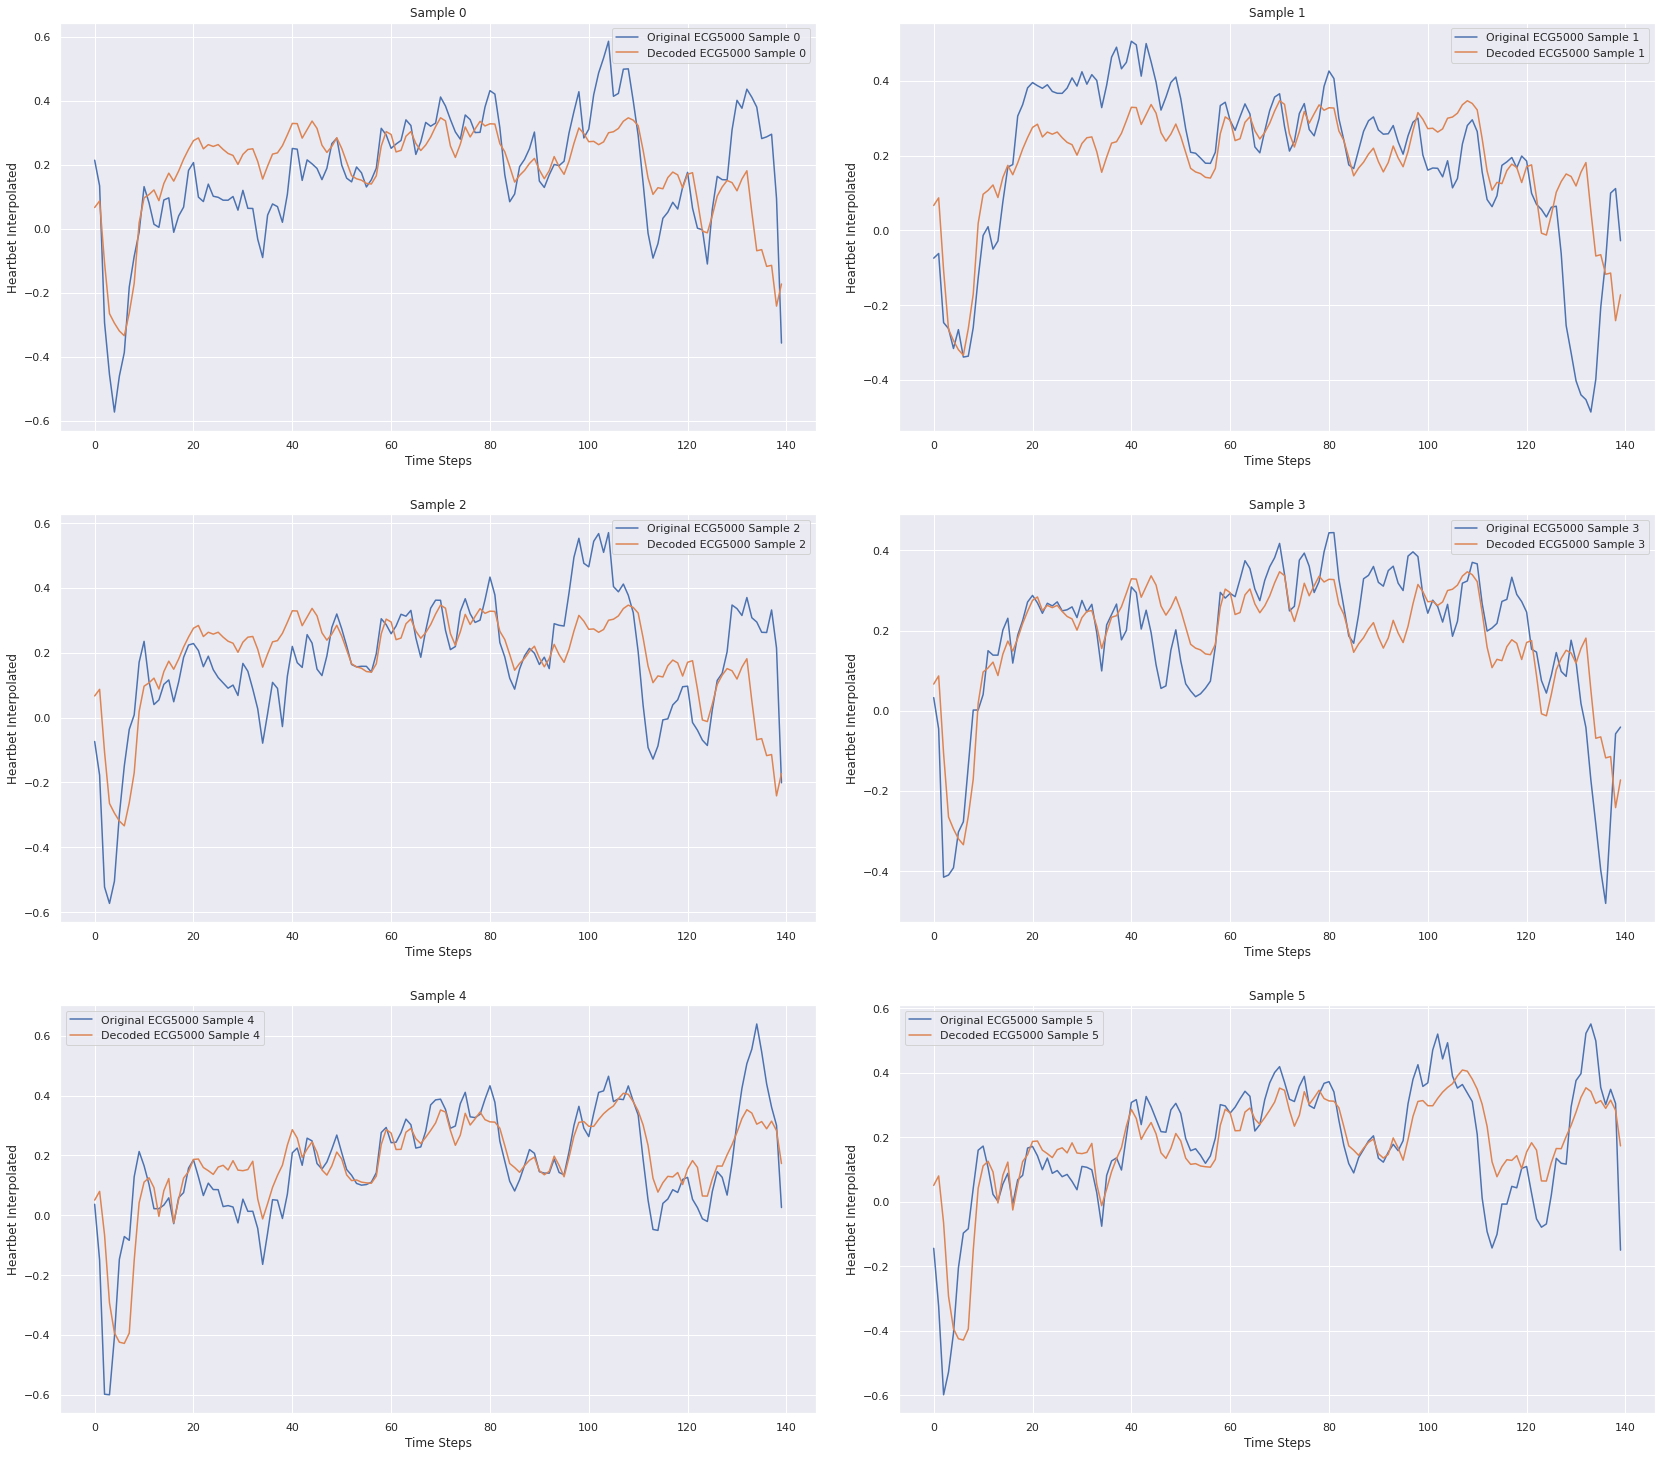

In [45]:
### Plot Multiple Samples
n_rows = 3                   
n_cols = 2

# Size Properties and layout design for tighter representation
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(23,20))
fig.tight_layout(w_pad=4, h_pad = 5)

# Subplotting
i = 0
for row in range(n_rows):
  for col in range(n_cols):
    axs[row, col].plot(new_x_train[i])
    axs[row, col].plot(new_decoded_ecg5000[i])
    axs[row, col].legend(["Original ECG5000 Sample {}".format(i), "Decoded ECG5000 Sample {}".format(i)])
    axs[row, col].set(xlabel = "Time Steps", ylabel = "Heartbet Interpolated", title = "Sample {}".format(i))
    i = i + 1
